In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

xgb = pd.read_csv('data/XGBoost_performance.csv')
cnn = pd.read_csv('data/CNN_performance.csv')
rnn = pd.read_csv('data/RNN_performance.csv')

In [2]:
scores = pd.concat([xgb, cnn, rnn])
scores

,model,embedding,accuracy,precision,recall,f1 score,roc auc
0,XGBoost,CBOW,0.906642,0.955230,0.936361,0.945701,0.926628
1,XGBoost,Skipgram,0.906728,0.954664,0.937074,0.945787,0.926486
2,XGBoost,Fasttext,0.908650,0.955085,0.938944,0.946945,0.928219
0,CNN,CBOW,0.806728,0.943674,0.826745,0.881348,0.750785
1,CNN,Skipgram,0.854464,0.889728,0.950137,0.918941,0.587648
2,CNN,Fasttext,0.881076,0.943740,0.917739,0.930558,0.885207
0,RNN,CBOW,0.917685,0.932164,0.976237,0.953691,0.920733
1,RNN,Skipgram,0.919586,0.937826,0.971809,0.954515,0.922010
2,RNN,Fasttext,0.926527,0.942346,0.975031,0.958410,0.937985


In [3]:
scores['method'] = scores['model'] + '-' + scores['embedding']
scores.drop(['model', 'embedding'], inplace = True, axis = 1)
scores

,accuracy,precision,recall,f1 score,roc auc,method
0,0.906642,0.955230,0.936361,0.945701,0.926628,XGBoost-CBOW
1,0.906728,0.954664,0.937074,0.945787,0.926486,XGBoost-Skipgram
2,0.908650,0.955085,0.938944,0.946945,0.928219,XGBoost-Fasttext
0,0.806728,0.943674,0.826745,0.881348,0.750785,CNN-CBOW
1,0.854464,0.889728,0.950137,0.918941,0.587648,CNN-Skipgram
2,0.881076,0.943740,0.917739,0.930558,0.885207,CNN-Fasttext
0,0.917685,0.932164,0.976237,0.953691,0.920733,RNN-CBOW
1,0.919586,0.937826,0.971809,0.954515,0.922010,RNN-Skipgram
2,0.926527,0.942346,0.975031,0.958410,0.937985,RNN-Fasttext


In [4]:
metrics = ['accuracy', 'precision', 'recall', 'f1 score', 'roc auc']

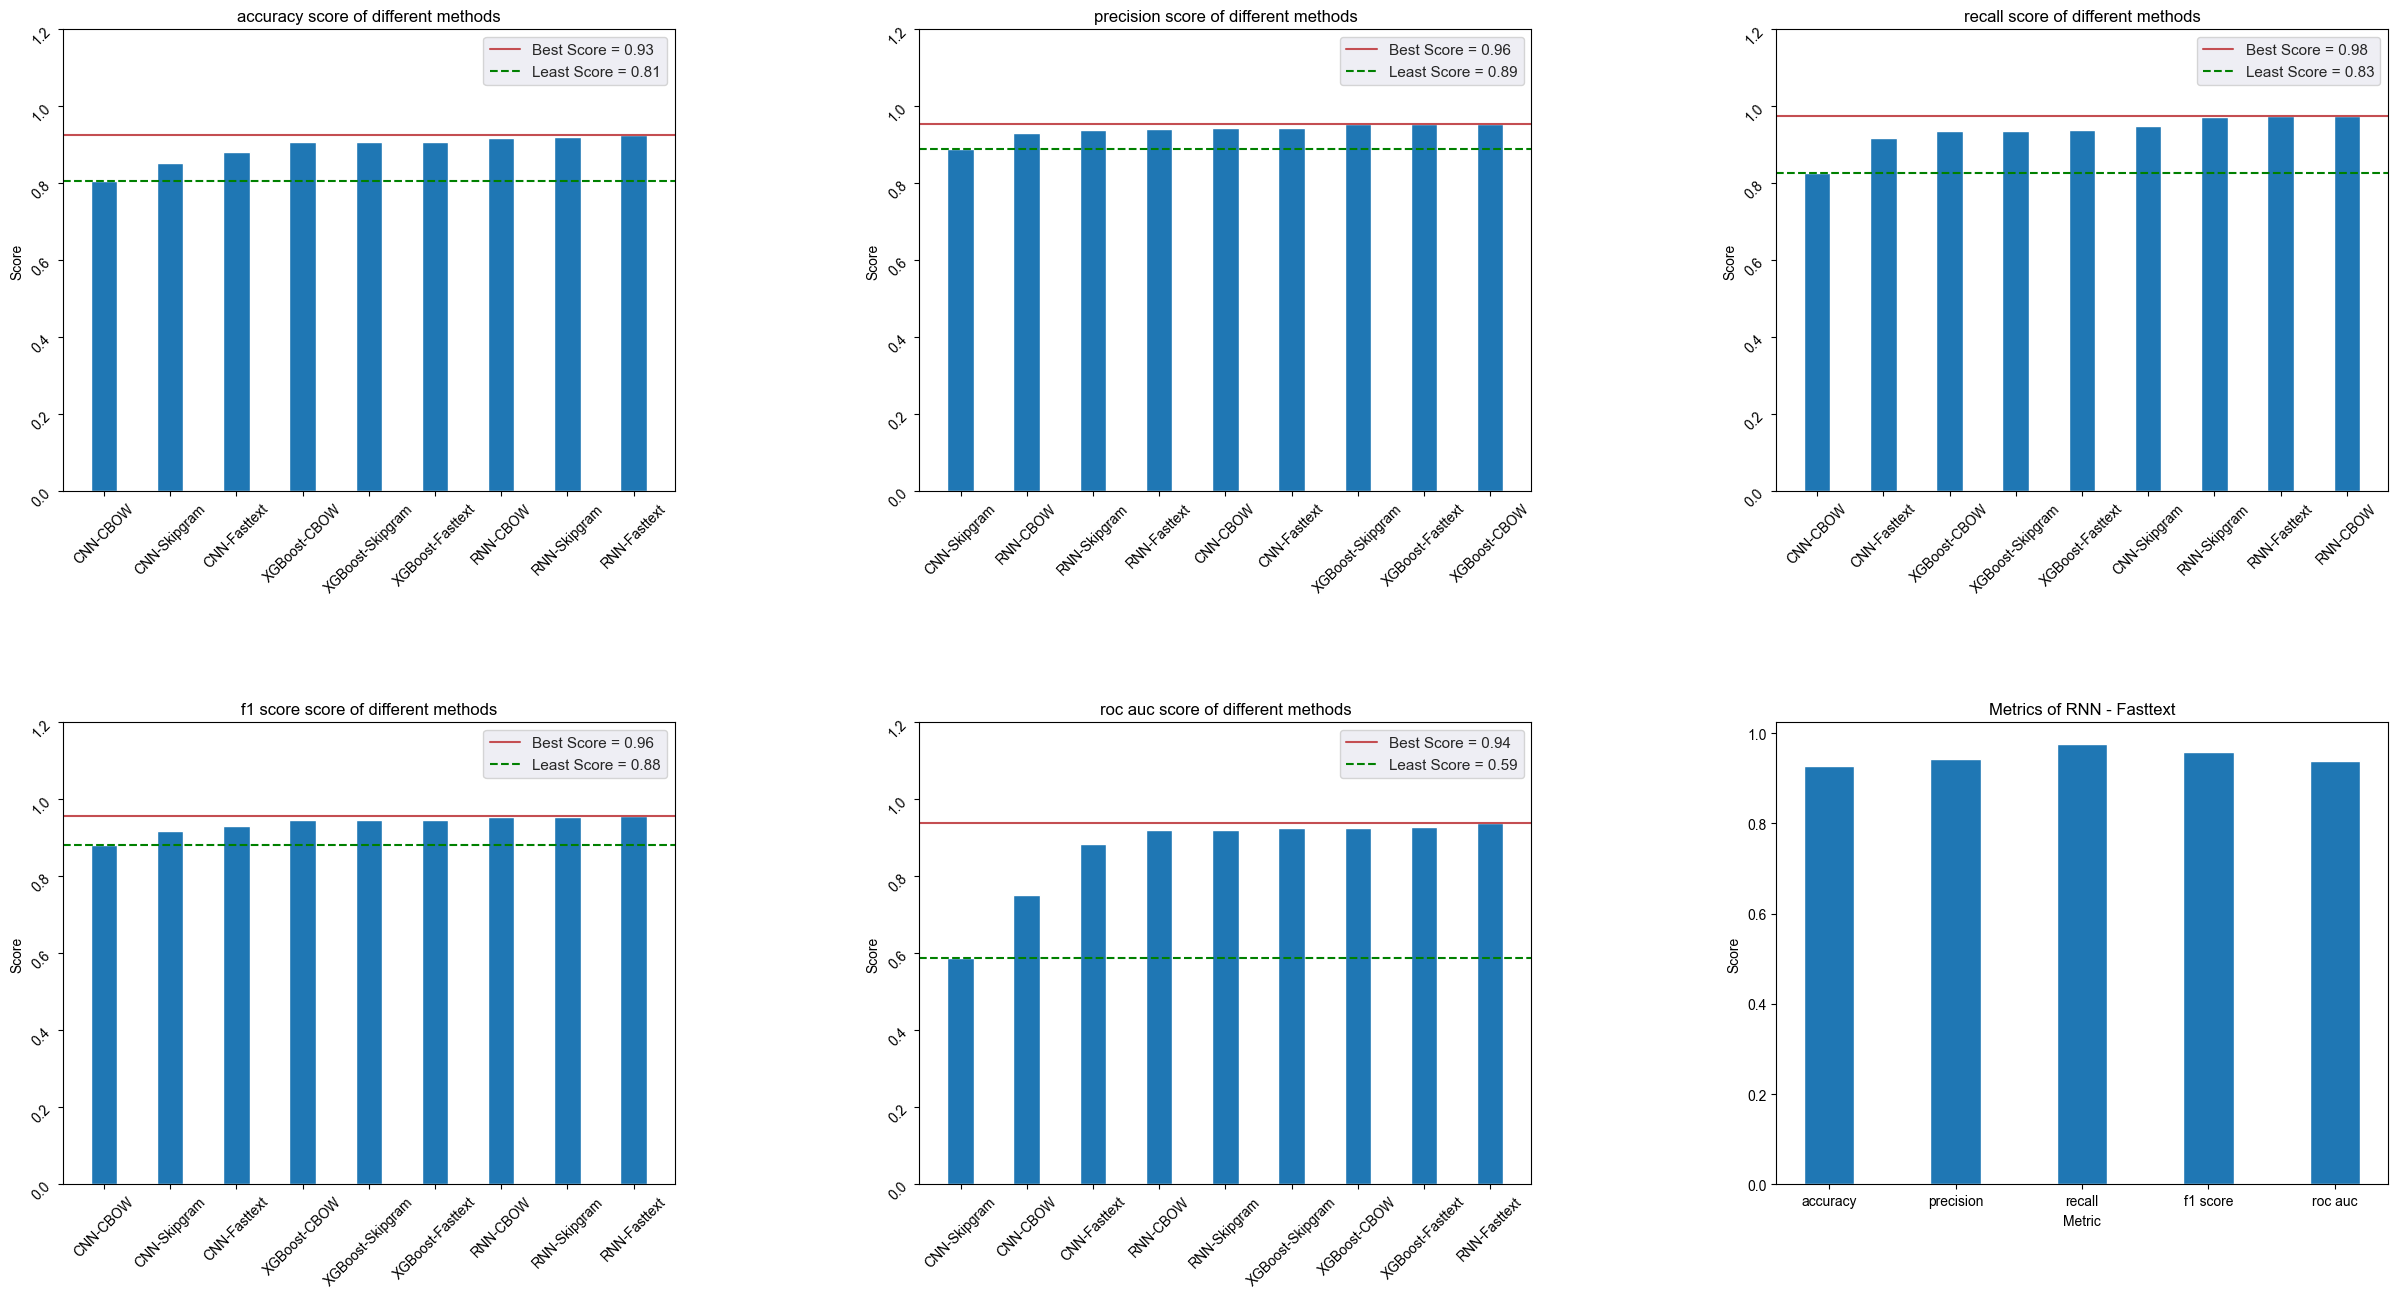

In [5]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 15))

for i in range(len(metrics)):
    sns.set_theme(style = 'darkgrid')
    best_acc = scores[['method', metrics[i]]].sort_values([metrics[i]])

    axes[i//3][i%3].bar(best_acc['method'], best_acc[metrics[i]], width = 0.4)
    axes[i//3][i%3].axhline(y = best_acc[metrics[i]].max(), color='r', linestyle='-', label = f'Best Score = {"{:.2f}".format(best_acc[metrics[i]].max())}')
    axes[i//3][i%3].axhline(y = best_acc[metrics[i]].min(), color='green', linestyle='--', label = f'Least Score = {"{:.2f}".format(best_acc[metrics[i]].min())}')

    axes[i//3][i%3].tick_params(labelrotation=45)
    axes[i//3][i%3].set_ylim(0, 1.2)
    axes[i//3][i%3].set_ylabel('Score')
    axes[i//3][i%3].set_title(f'{metrics[i]} score of different methods')
    axes[i//3][i%3].legend()

x = scores[scores['method'] == 'RNN-Fasttext'].to_numpy().tolist()[0][:5]
axes[1][2].bar(metrics, x, width = 0.4)
axes[1][2].set_xlabel('Metric')
axes[1][2].set_ylabel('Score')
axes[1][2].set_title('Metrics of RNN - Fasttext')
plt.subplots_adjust(hspace=0.5, wspace=0.4)

plt.savefig('figs/performance_metrics.png')
plt.show()



In [6]:
import pandas as pd
import warnings
from performance_utils import calc_metrics, get_roc_auc
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from keras.optimizers import Adam
from keras.utils import set_random_seed
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

warnings.filterwarnings('ignore')

ft = pd.read_csv('data/fasttext_100.csv')

set_random_seed(42)

# Load your data
X = ft.drop(['overall','reviewText', 'preprocessed_text', 'embeddings'], axis = 1)
y = ft['overall']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)



model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], 1)))  # Adjust input_shape based on your data
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer with 1 neuron for binary classification

# Compile the model
model.compile(optimizer=Adam(lr = 0.7), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
#13
model.fit(X_train, y_train, epochs=45, batch_size=128, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)


2024-03-18 23:12:10.261102: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-18 23:12:10.262036: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-18 23:12:10.262645: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-18 23:12:10.264204: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-18 23:12:10.264862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/45


2024-03-18 23:12:11.810343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-18 23:12:11.862979: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1464/1464 [==============================] - 39s 26ms/step - loss: 0.3903 - accuracy: 0.8682 - val_loss: 0.3758 - val_accuracy: 0.8682
Epoch 2/45
1464/1464 [==============================] - 37s 25ms/step - loss: 0.3467 - accuracy: 0.8682 - val_loss: 0.3473 - val_accuracy: 0.8682
Epoch 3/45
1464/1464 [==============================] - 37s 25ms/step - loss: 0.3153 - accuracy: 0.8744 - val_loss: 0.3812 - val_accuracy: 0.8208
Epoch 4/45
1464/1464 [==============================] - 37s 25ms/step - loss: 0.2791 - accuracy: 0.8907 - val_loss: 0.2641 - val_accuracy: 0.8944
Epoch 5/45
1464/1464 [==============================] - 37s 25ms/step - loss: 0.2531 - accuracy: 0.9019 - val_loss: 0.2450 - val_accuracy: 0.9049
Epoch 6/45
1464/1464 [==============================] - 37s 25ms/step - loss: 0.2389 - accuracy: 0.9079 - val_loss: 0.2508 - val_accuracy: 0.9123
Epoch 7/45
1464/1464 [==============================] - 37s 25ms/step - loss: 0.2354 - accuracy: 0.9093 - val_loss: 0.2368 - val_accura

In [19]:
X = ft.drop(['overall', 'embeddings'], axis = 1)
y = ft['overall']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

y_pred = model.predict(X_test.drop(['reviewText','preprocessed_text'], axis = 1))
y_pred = (y_pred > 0.5).astype(int)

test_result = X_test[['reviewText', 'preprocessed_text','processed_len','review_length']]
test_result['actual'] = y_test
test_result['predicted'] = y_pred

1464/1464 [==============================] - 14s 10ms/step


In [31]:
bad_predictions = test_result[test_result['actual'] != test_result['predicted']]
bad_predictions

,reviewText,preprocessed_text,processed_len,review_length,actual,predicted
214542,"It's a beautiful day here in New Orleans, calm...",beautiful day new orleans calm breeze barely s...,603,891,0,1
136386,Call of Duty Quality as expected... If you are...,call duty quality expected looking sort story ...,586,1028,0,1
99108,This game was great when it was first released...,game great when first released almost years ag...,629,995,0,1
96195,"Honestly, I thought I was getting an incredibl...",honestly thought getting incredible bargain bu...,866,1358,0,1
209005,This device works by sending out CO2 from a Pr...,device works sending co propane tank thought s...,143,245,0,1
...,...,...,...,...,...,...
221983,What a load of crap. I just installed it in my...,what load crap just installed civic not see re...,410,637,0,1
54184,I bought this for the added bots in multiplaye...,bought added bots multiplayer despite gameplay...,273,418,0,1
194198,I stooped playing Smackdown vs. Raw games beca...,stooped playing smackdown vs raw games got fed...,159,240,1,0
15987,One of the poorest games ever developed. The ...,one poorest games ever developed opportunity m...,174,274,1,0


(2425, 6)


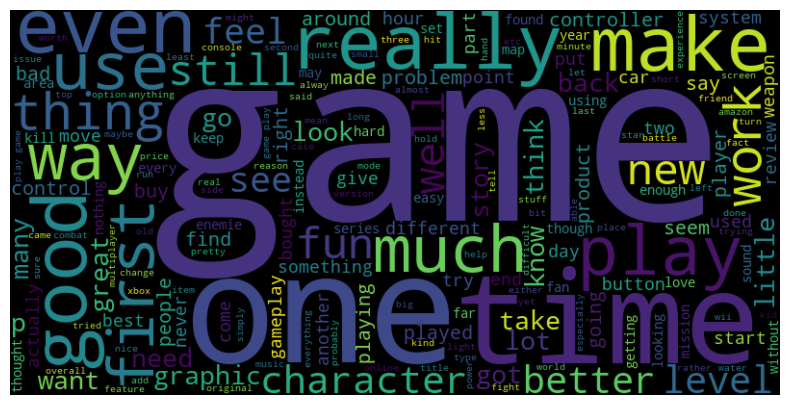

In [32]:
from wordcloud import WordCloud

fp = bad_predictions[bad_predictions['actual'] == 0]
print(fp.shape)
text_data = ' '.join(fp['preprocessed_text']) 
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text_data)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.savefig('figs/false_positive_wordcloud.png')
plt.show()

- These are actually negative/bad review but we can clearly see words like good, better, great, best which indicate positivity.

(1015, 6)


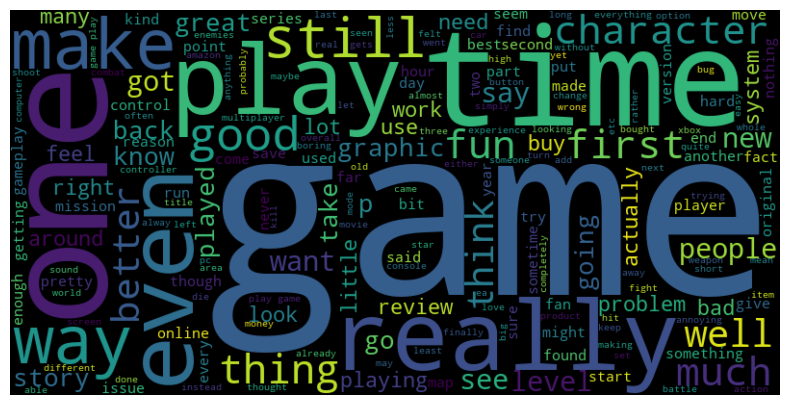

In [33]:
from wordcloud import WordCloud

fn = bad_predictions[bad_predictions['actual'] == 1]
print(fn.shape)
text_data = ' '.join(fn['preprocessed_text']) 
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text_data)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.savefig('figs/false_negative_wordcloud.png')
plt.show()

-  This does not say a lot about why these are mislabeled as bad reviews.
- Look more closely.

<Axes: xlabel='processed_len', ylabel='Count'>

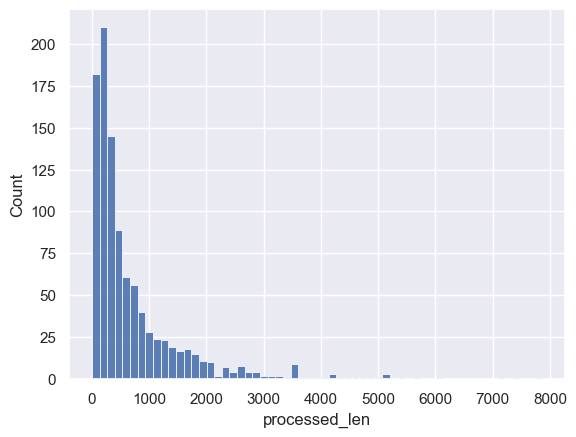

In [37]:
sns.histplot(fn['processed_len'], alpha = 0.9)

In [42]:
good_predictions = test_result[(test_result['actual'] == 0) | (test_result['actual'] == 1)]

In [43]:
good_predictions[['review_length','processed_len']].describe()

,review_length,processed_len
count,46820.000000,46820.000000
mean,1019.813306,657.813968
std,1446.572785,946.684210
min,3.000000,3.000000
25%,215.000000,136.000000
50%,506.000000,320.000000
75%,1208.000000,775.000000
max,32587.000000,21256.000000


In [48]:
fp[['review_length','processed_len']].describe()

,review_length,processed_len
count,2425.000000,2425.000000
mean,1016.625155,654.405361
std,1457.489460,951.559162
min,13.000000,5.000000
25%,254.000000,161.000000
50%,545.000000,342.000000
75%,1205.000000,767.000000
max,20872.000000,13419.000000


In [49]:
fn[['review_length','processed_len']].describe()

,review_length,processed_len
count,1015.000000,1015.000000
mean,1139.668966,726.249261
std,1468.435603,949.319899
min,4.000000,4.000000
25%,282.500000,172.000000
50%,594.000000,375.000000
75%,1344.000000,851.000000
max,12332.000000,7875.000000


 - We can see that the processed length of reviews is highest for false negatives compared to false positives and good predictions. 

- We might want to set a cap to consider only first 'n' words of the review and retry to mitigate this problem.

In [53]:
fn['reviewText'].tolist()[:4]

['I have heard over and over that people found this game to be too hard to play. In reality, it was the easiest, more enjoyable game I have ever played. The battle system was wonderful. You can avoid fighting if you want to, you can change the number of people who do fight (and who appear on your screen), and you can have a sort of "mini-army" where you can automatically have your party members fight for you as you walk around.It was EXTREMELY realistic, and I loved it. I never felt like anything was wasted or annoying (except the chocobo thing).',
 'I put a few hours in on singleplayer, and am now not sure how to start another separate game for local co op, PLEASE HELP! Can I start a multiplayer game with a new character and not have it effect my singleplayer game save? I don\'t see the option where to start a local game now that I have begun a singleplayer game, all I see is the "continue" option.Save me!!!!',
 "I have to admit I was worried about buying this gane after being torched

- There might not be enough evidence to say why these good reviews have been identified as bad reviews.